<a href="https://colab.research.google.com/github/mdominguezd/DomainAdaptationCashewCropMapping_MGIThesis/blob/main/04_Cashew%20crop%20models/04_01_TrainUNet_No_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using U-Net model to predict cashew crop extent remote sensing images

## 1) Import data and create dataset

In [1]:
!wget -O Tanzania.zip https://www.dropbox.com/scl/fi/hrvixl2a6amc7y8trza2d/PlanetTanzania.zip?rlkey=khxf3vp2cmm3rue7fqwi9rmxp&dl=0
!wget -O IvoryCoast.zip https://www.dropbox.com/scl/fi/lymeixhclxng0gowe9sp7/PlanetIvoryCoast.zip?rlkey=4zuq1y9bed85ruk3lmzkpqwgn&dl=0

--2023-10-16 08:39:33--  https://www.dropbox.com/scl/fi/hrvixl2a6amc7y8trza2d/PlanetTanzania.zip?rlkey=khxf3vp2cmm3rue7fqwi9rmxp
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf7b41a8f6e7000ba4ae1fda519.dl.dropboxusercontent.com/cd/0/inline/CFspOJW47DdoUeJn_IhwHjD0t-LkiXvC8Kn-2AZaR0BMmXOgeCfovur5tFrM3-282llI4Nc4o5qI13atVzSbA-a-jBBr0UNIP-PNpDvBKco7BMo1pInHKlE-8M5pxuhl0AXTY7YHccqBcbpQ-MqFx7u5/file# [following]
--2023-10-16 08:39:35--  https://ucf7b41a8f6e7000ba4ae1fda519.dl.dropboxusercontent.com/cd/0/inline/CFspOJW47DdoUeJn_IhwHjD0t-LkiXvC8Kn-2AZaR0BMmXOgeCfovur5tFrM3-282llI4Nc4o5qI13atVzSbA-a-jBBr0UNIP-PNpDvBKco7BMo1pInHKlE-8M5pxuhl0AXTY7YHccqBcbpQ-MqFx7u5/file
Resolving ucf7b41a8f6e7000ba4ae1fda519.dl.dropboxusercontent.com (ucf7b41a8f6e7000ba4ae1fda519.dl.dropboxusercontent.com)... 162.125.2.15

Import necessary libraries

In [2]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
from zipfile import ZipFile
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as T
from torch.utils.data import random_split
from skimage import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import shutil
from torch.autograd import Function

### Unzip and remove zipped files

In [3]:
with ZipFile("Tanzania.zip", 'r') as zipped:
    zipped.extractall(path="./")
with ZipFile("IvoryCoast.zip", 'r') as zipped:
    zipped.extractall(path="./")

os.remove('Tanzania.zip')
os.remove('IvoryCoast.zip')

## 2) Create DataSet Classes

### 2.1) Set Image Augmentation transforms.

In [4]:
np.random.seed(1)

def brightness(i, increase = 0.4, prob = 0.5):
    if i.unique().shape[0] != 2: # Hard code
        p = np.random.random(1)
        if p < prob:
            p_inc = np.random.random(1)
            i = i*(1 + increase*p_inc)
            i[i>1] = 1.0
        else:
            p_dec = np.random.random(1)
            i = i*((1 - increase*p_dec))

    return i.float()


transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    # T.RandomResizedCrop((256,256), scale = (0.8,1)),
    T.Lambda(brightness)
    ])

### 2.2.) Create Source and Target Class

In [69]:
class Img_Dataset(Dataset):
  def __init__(self, img_folder, transform = None, split = 'Train'):
    self.img_folder = img_folder
    self.transform = transform
    self.split = split

  def __len__(self):
    return sum([self.split in i for i in os.listdir(self.img_folder)])//2

  def plot_imgs(self, idx):
    fig, ax = plt.subplots(1,2,figsize = (12,6))

    im, g = self.__getitem__(idx)

    ax[0].imshow(im[[2,1,0],:,:].permute(1,2,0))
    ax[0].set_title('Planet image')
    ax[1].imshow(g[0,:,:])
    ax[1].set_title('Cashew crops GT')

  def __getitem__(self, idx):
    #__getitem__ asks for the sample number idx.

    conversion = T.ToTensor()
    img = io.imread(fname = self.img_folder + '/Cropped' + self.img_folder + self.split + 'StudyArea_{:05d}'.format(idx) + '.tif').astype(np.float32)

    # img = img/np.max(img, 0)

    img = img/1500

    img[img > 1] = 1

    img = conversion(img).float()

    img = torchvision.datapoints.Image(img)

    GT = io.imread(fname = self.img_folder + '/Cropped' + self.img_folder + self.split + 'GT_{:05d}'.format(idx) + '.tif').astype(np.float32)

    GT = torch.flip(conversion(GT), dims = (1,))

    GT = torchvision.datapoints.Image(GT)

    if self.transform != None:
        GT, img = self.transform(GT, img)

    return img, GT

In [71]:
DS = Img_Dataset('Tanzania', transform)
# DS = Tanzania_Dataset('Tanzania', transform)

DS.__len__()

1574

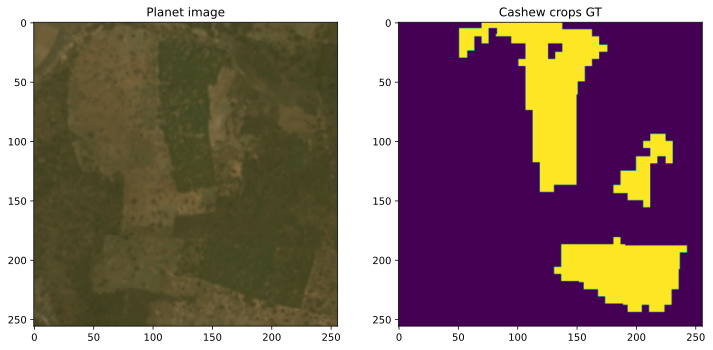

In [49]:
DS.plot_imgs(1)

## 3) Set Hyperparameters

In [120]:
#Set params
batch_size = 16
epochs = 4
learning_rate = 0.3

loss_function = torch.nn.CrossEntropyLoss()

# DOMAIN
domain = 'target'

## 4) Split Datasets (Train, Val, test)

In [121]:
CIV_train_DS = Img_Dataset('IvoryCoast', transform)
CIV_val_DS = Img_Dataset('IvoryCoast', split = 'Validation')
CIV_test_DS = Img_Dataset('IvoryCoast', split = 'Test')

TNZ_train_DS = Img_Dataset('Tanzania', transform)
TNZ_val_DS = Img_Dataset('Tanzania', split = 'Validation')
TNZ_test_DS = Img_Dataset('IvoryCoast', split = 'Test')

if domain == 'source':
  # Create data loaders
  train_loader = torch.utils.data.DataLoader(dataset=CIV_train_DS, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset=CIV_val_DS, batch_size=batch_size, shuffle=False)
else:
  # Create data loaders
  train_loader = torch.utils.data.DataLoader(dataset=TNZ_train_DS, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset=TNZ_val_DS, batch_size=batch_size, shuffle=False)

In [122]:
iterable_train_loader = enumerate(train_loader)

## 5) Build the model

### 5.1) Building blocks of a UNet

Take from: https://github.com/milesial/Pytorch-UNet/tree/master

In [123]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # print(diffY, diffX)

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

### 5.2 Build the network class

Taken from: https://github.com/milesial/Pytorch-UNet/tree/master

THIS NEEDS TO BE ADAPTED TO BE DIVIDED IN:
- Feature extractor
- Classifier (Segmentator (?))

In [124]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, starter = 8, up_layer = 3):

        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.starter = starter
        self.up_layer = up_layer

        self.inc = (DoubleConv(n_channels, self.starter))
        self.down1 = (Down(self.starter, self.starter*(2**1)))
        self.down2 = (Down(self.starter*(2**1), self.starter*(2**2)))
        self.down3 = (Down(self.starter*(2**2), self.starter*(2**3)))
        factor = 2 if bilinear else 1
        self.down4 = (Down(self.starter*(2**3), self.starter*(2**4) // factor))
        self.up1 = (Up(self.starter*(2**4), self.starter*(2**3) // factor, bilinear))
        self.up2 = (Up(self.starter*(2**3), self.starter*(2**2) // factor, bilinear))
        self.up3 = (Up(self.starter*(2**2), self.starter*(2**1) // factor, bilinear))
        self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))
        self.outc = (OutConv(self.starter, n_classes))

        self.apply(self._init_weights)

    def Down(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        return x1, x2, x3, x4, x5

    def return_FE(self, x, up_layer = 0):

        down_copies = self.Down(x)

        x1, x2, x3, x4, x5 = down_copies

        if up_layer == 0:
            x = x5
        if up_layer >= 1:
            x = self.up1(x5, x4)
        if up_layer >= 2:
            x = self.up2(x, x3)
        if up_layer >= 3:
            x = self.up3(x, x2)
        if up_layer >= 4:
            x = self.up4(x, x1)

        return x, down_copies

    def return_Seg(self, x, down_copies, up_layer = 0):

        x1, x2, x3, x4, x5 = down_copies

        if up_layer == 0:
            x = self.up1(x5, x4)
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
        if up_layer == 1:
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
        if up_layer == 2:
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
            return logits
        if up_layer == 3:
            x = self.up4(x, x1)
            logits = self.outc(x)
        if up_layer >= 4:
            logits = self.outc(x)

        return logits

    def forward(self, x):
        features, down_copies = self.return_FE(x, self.up_layer) # Feature extractor
        logits = self.return_Seg(features, down_copies, self.up_layer) # Classifier
        return logits


    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

## 6) Train model

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


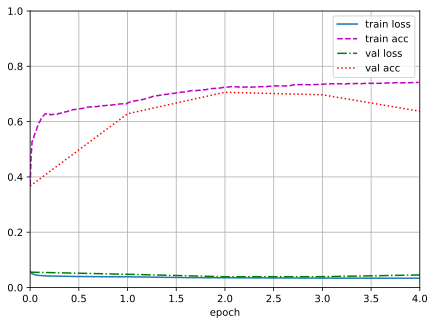

In [126]:
!pip install d2l==0.14.2 -q
from d2l import torch as d2l
from collections import deque
from statistics import mean


def evaluate(net, validate_loader, loss_function):
  #You need to set the network to eval mode when using batch normalization (to
  #be consistent across evaluation samples, we use mean and stddev computed
  #during training when doing inference, as opposed to ones computed on the
  #batch) or dropout (you want to use all the parameters during inference).
  net.eval()  # Set the model to evaluation mode
  device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(4)
  #This line reduces the memory by not tracking the gradients. Also to be used
  #during inference.
  with torch.no_grad():
    for i, (inputs, GTs) in enumerate(validate_loader):
      #Send inputs and GTs them to the computation device (i.e. GPU). The GTs tensor
      #has to be converted to nn.LongTensor type (a type of integer) and turned into
      #a 3D tensor by removing dimension 1 with the squeeze() function.
      inputs = inputs.to(device)
      GTs = GTs.type(torch.long).squeeze().to(device)
      pred = network(inputs)
      # pred = pred[:,0,:,:].float()
      # print(pred[0,0,0], GTs[0,0,0])
      loss = loss_function(pred, GTs)
      overall_accuracy = (pred.max(1)[1]==GTs).float().mean()
      metric.add(loss, GTs.shape[0], overall_accuracy, 1)
  return metric


number_epochs = epochs

animator = d2l.Animator(xlabel='epoch', xlim=[0, number_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'val loss', 'val acc'],
                        fmts=('-', 'm--', 'g-.', 'r:'),
                        figsize=(7, 5))

network = UNet(n_channels=4, n_classes=2, bilinear=True)
network.to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
#Training metrics are computed as a running average of the last x samples
loss_train = deque(maxlen=len(train_loader))
accuracy_train = deque(maxlen=len(train_loader))

for epoch in range(number_epochs):
  #Validation phase:
  metric_val = evaluate(network, val_loader, loss_function)
  animator.add(epoch,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))

  #Training phase:
  network.train() #indicate to the network that we enter training mode
  for i, (inputs, GTs) in enumerate(train_loader):
    inputs = inputs.to(device)
    GTs = GTs.type(torch.long).squeeze().to(device)
    #We set the gradients of the model to 0.
    optimizer.zero_grad()
    pred = network(inputs)
    loss = loss_function(pred, GTs)
    overall_accuracy = (pred.max(1)[1]==GTs).float().mean()
    #We accumulate the gradients...
    loss.backward()
    #...and we update the parameters according to the gradients.
    optimizer.step()
    loss_train.append(loss.item()/GTs.shape[0])
    accuracy_train.append(overall_accuracy.item())
    animator.add(epoch+i/len(train_loader),
                      (mean(loss_train), mean(accuracy_train), None, None))


  if (epoch//2 == epoch/2):
      #After each training epoch, reduce the learning rate by a factor of 0.2
      optimizer.param_groups[0]['lr'] *= 0.2

metric_val = evaluate(network, val_loader, loss_function)
animator.add(epoch+1,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))


In [127]:
loss

tensor(0.6698, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [ ]:
torch.save(network, 'U_Net_TargetOnlyTNZwithImAug.pt')

## 7) Assess model predictions

In [94]:
def F1(pred, gt):

    cl = pred - gt.numpy()
    FN = np.sum(cl == -1)
    FP = np.sum(cl == 1)
    TN = np.sum(pred[((pred == 0)&(cl == 0))[0]])
    TP = np.sum(pred[((pred == 1)&(cl == 0))[0]])

    if TP == 0 :
      F1 = 0
    else:
      prec = TP/(TP+FP)
      recall = TP/(TP+FN)

      F1 = 2*(prec*recall)/(prec+recall)

    return F1

t_DS = Img_Dataset('Tanzania', split = 'Test')
c_DS = Img_Dataset('IvoryCoast', split = 'Test')

l = []
oa = []

for i in range(t_DS.__len__()):
  img, gt = t_DS.__getitem__(i)

  pred = network(img[None, :, :, :].to(device))
  pred = pred[0,:,:,:].max(0)[1].cpu().numpy()

  overall_accuracy = np.mean(pred == gt.numpy())
  f1 = F1(pred, gt)

  l.append(f1)
  oa.append(overall_accuracy)

  if f1 > 0.95:
      img = img[[2,1,0], :, :].permute(1,2,0)

      f, ax = plt.subplots(1,2,figsize = (16,8))
      ax[0].imshow(img)
      ax[0].imshow(gt[0], alpha = 0.4, cmap = 'gray', vmin = 0, vmax = 1)
      ax[0].set_title('Reference data')

      ax[1].imshow(img)
      ax[1].imshow(pred, alpha = 0.4, cmap = 'gray', vmin = 0, vmax = 1)
      ax[1].set_title('Prediction')

      plt.suptitle('Overall Accuracy: ' + str(overall_accuracy) + '\nF1-Score: '+str(f1))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [95]:
mean(l)

0.4608663663216228

In [96]:
mean(oa)

0.7410990397135416

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, network.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

270978


In [107]:
batch = next(iterable_train_loader)

pred = network(batch[1][0].to(device))

# print(loss_function(pred, batch[1][1].to(device)))
print('This is batch number '+ str(batch[0]))
fig, axs = plt.subplots(batch_size, 3)
fig.set_size_inches(15,5*batch_size)
for i in range(batch_size):
  axs[i,0].imshow(batch[1][0].permute(0,2,3,1)[i,:,:,[2,1,0]], vmin =0, vmax = 1)
  axs[i,1].imshow(batch[1][1][i,0,:,:],cmap=plt.get_cmap('gray'),vmin=0,vmax=1)
  axs[i,2].imshow(pred[i,:,:,:].max(0)[1].cpu(),cmap=plt.get_cmap('gray'))
axs[0,0].set_title('Image')
axs[0,1].set_title('GT')
axs[0,2].set_title('Prediction')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


This is batch number 0


Text(0.5, 1.0, 'Prediction')

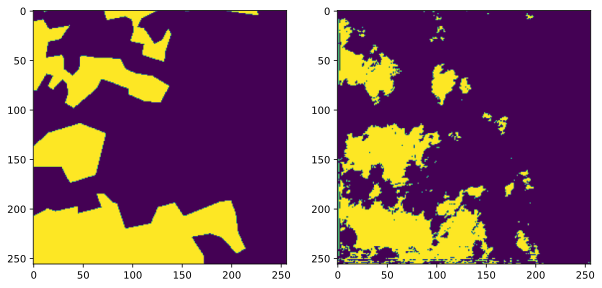

In [ ]:
im, gt = DS.__getitem__(700)
pred = network(im[None, :, :, :].to(device))
pred_ = pred[0,:,:,:].max(0)[1].cpu().numpy()

figs, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(gt[0])
ax[1].imshow(pred_)